Plans for this Document:

### Term Counting Approach

* to count products...
* use a pre trained library, for example glove? and detect all words which are close to the original ones.
    * pretrained wont be good, but we can train our own model and then check if that is worthwhile.
* PER POST (IN A THREAD)
* to count hazards...
* for basic contaminants we can use pre trained library.
* for the others we can just search them specificall (for example bisphenol, or others which have very unique words.)
    * optional extra step: use somethign which will find typos of it. (related to word distance calculator things. but this will take much longer time to process)
   

In [1]:
#if jupyternotify is installed, we can add %notify to a cell to get an alert when it ifnished running
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import metrics_helpers as indicators
import pickle as pk
import gc
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
def dt_to_int(dt): #datetime to integer
    return dt.astype('int')/(10**9)

In [4]:
with open('/Users/sma/Documents/INRAE internship/scrape-git/facebook/FULL_untypod_dict.pkl', 'rb') as f:
    netmums = pk.load(f)

#with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/allposts_rerun.pkl', 'rb') as f:
#    netmums = pk.load(f)
    
#with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/netmums_subset_keys.txt', 'r') as f:
#    keys = [url.strip() for url in f.readlines()]
        

In [5]:
#netmums = {key:netmums[key] for key in keys}

In [6]:
#  #netmums
nm_ind = indicators.indicators(netmums, fb=False)
#  #this one takes long, around 20 seconds I think.
#  
#  nm_ind.add_term_counts()
#  nm_ind.add_url_term_counts()
#  nm_ind.add_total_likes()
#  nm_ind.add_available_comments()
#  nm_ind.add_comment_activity()
#  nm_ind.add_num_unique_posters()
#  nm_ind.add_num_urls()
#  nm_ind.add_avg_post_length()
#  nm_ind.add_post_time()
#  nm_ind.add_lexical_richness()
#  nm_ind.add_term_distance_simple()
#  
netmums = nm_ind.results_dict

In [7]:
hazards = {
'Chemical contaminants': [],
'Endocrine disruptor': ["endocrine","estrogen"],
'FOOD PRESERVATIVES, SWEETENERS AND ADDITIVES':["preservatives","sweeteners","additives"],
"Pesticides":[],
"Veterinary drugs":["animal drugs","vet drugs"],
'GMO':['GM',"genetically modified"],
"Metals":[],
"Mycotoxin":[],
"Bisphenol A":['BPA', 'Bisphenol','BisphenolA'],
'Furan':[],
'DON': #(note that this acronym nobody uses and all results are from words like "don't")
["deoxynivalenol",
"vomitoxin"],
'DIOXIN AND PCB':["Dioxin","PCB","biphenyls"],
'MOSH and MOAH':["hydrocarbons","saturated hydrocarbons","MOAH", 'MOH',"aromatic hydrocarbons"], #mosh not incl bc other meanings
'Nitrates':[],
"Acrylamid":["Acrylamide"],
"phthalates":[],
"Microbiologic contaminants":
["spores",
"mold",
"mould",
"virus",
"microbes",
"contaminated"],
"Salmonella":[],
"Campylobacter":[],
"Listeria":[],
"EColi":["E coli"],
"Cronobacter":[],
"Histamine":[],
'other bacteria':["bacteria"],
"Virus":[],
"Parasites":[],
'Related Terms':["carcinogen","chemicals", "toxic", "toxin", "poisonous", "fungus", "food poisoning", "hazard","EFSA","European Food Safety Authority"]
}

products = {
'infant formula':
["formula","baby formula", "bottle fed", "bottle-fed", "bottle"] #should "milk" be added? if so, how can it be done w.o. adding breastmilk results?
,'sterilized vegetable mixed with fish':
["veggie baby food","vegetable baby food",
"veg puree", "veg purée"]
,'fresh fruit puree mildly processed':
["fruit puree","fruit baby food", "fruit purée", "applesauce"]
,'infant cereals':
["cereal for baby", "cereal", "porridge", "oats", "oatmeal"]
,'other':
["jar food", "baby food", "jarred", "premade food", "puree", "purée", "jarred food"
,"yoghurt", "pudding"]
}

#IMPORTANT!: terms used for count vectorizer must be lower-case o.w. get 0 matches
hazards = {key.lower():[v.lower() for v in value] + [key.lower()] for key,value in hazards.items()}
products = {key.lower():[v.lower() for v in value]+[key.lower()] for key,value in products.items()}

In [8]:

extras = {\
'baby_food_brands':
['ellas',
'organix',
'heinz baby',
"plum baby",
'little angels',
'farleys'],
'formula_brands':['sma','aptamil comfort','infasoy','nutramigen','neocate','powdered milk','comfort milk'],
 'food_or_formula_brands':
['aptamil', # formula and cereals.
'hipp organic',# - formula and baby food
'cow gate','cow and gate','c g',
'mamia'],
##NON BRAND SIGNALS##
'cereal':['baby_cereal','baby riceporridge','baby rice','baby porridge'],
'baby_food':['mashed','tinned','premade','canned','jarred','pouches','pouch','ready made','readymade','cartons'],  
#INDICATORS TO BE USED IN CONJUNCTION WITH 'baby food' label: this way we 
#can observe if both terms are used in a document (but are not used right next to each other.)
'fruit':['fruit'],
'vegetable':['vegetable'],
'baby':['infant', 'baby' ,'for littles']
         }


In [9]:
import re

def make_phrases(list_of_phrases, text):
    """
    convert phrases to bigrams within a larger text corpus.
    example: "I love collard greens for breakfast" -> "I love collard_greens for breakfast"
    example: "I love collard-greens for breakfast" -> "I love collard_greens for breakfast"
    """
    for phrase in list_of_phrases:
        #spaces
        text = re.sub(phrase, re.sub(' ', '_',phrase), text)
        #hyphens
        text = re.sub(re.sub(' ', '-', phrase), re.sub(' ', '_',phrase), text)
    return text

In [10]:
h = [item for val in hazards.values() for item in val]
p = [item for val in products.values() for item in val]
e = [item for val in extras.values() for item in val]

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

phrases = {'baby formula', 'baby cereal'}.union({item for item in p + h + e if ' ' in item})

#step 1: text_dict (for posts version this will be different.)
text_dict = nm_ind.text_dict

#step 2 : convert the relevant phrases to bigrams with re.sub
text_dict = {key: make_phrases(phrases, text) for key, text in text_dict.items()}

#replace "don't" with "do not" (so that we don't get false positives for don count.)
for key in text_dict:
    text_dict[key] = re.sub('don\'t', 'do not', text_dict[key])

#step 3: count occurences using countvectorizer
vocab = p + h + e
vocab = [re.sub(' ','_',item) for item in vocab]
vocab = set(vocab)
term_counter = CountVectorizer(vocabulary = vocab, stop_words = 'english')
counts = term_counter.fit_transform(text_dict.values())


#note that hyphens will be treated as spaces by countvectorizer

In [12]:
counts = counts.toarray() #run once
count_dict = {}
for num, key in enumerate(text_dict.keys()):
    #dict of 'term':count for each document
    count_dict[key] = {key: counts[num][value] for key, value in term_counter.vocabulary_.items()}

In [13]:
countdf = pd.DataFrame.from_dict(count_dict).transpose()
countdf

,acrylamid,acrylamide,additives,animal_drugs,applesauce,aptamil,aptamil_comfort,aromatic_hydrocarbons,baby,baby_cereal,...,veg_puree,veg_purée,vegetable,vegetable_baby_food,veggie_baby_food,vet_drugs,veterinary_drugs,virus,vomitoxin,yoghurt
https://www.netmums.com/coffeehouse/drop-clinic-984/bottle-feeding-559/201947-aptamil-hungry-baby-making-lo-sick.html,0,0,0,0,0,12,0,0,24,0,...,0,0,1,0,0,0,0,0,0,0
https://www.netmums.com/coffeehouse/being-mum-794/child-health-safety-1028/715809-immunisations-really-necessary.html,0,0,0,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,2,0,0
https://www.netmums.com/coffeehouse/being-mum-794/children-4-11-years-60/1857707-water-bottle-school-doesnt-leak.html,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
https://www.netmums.com/coffeehouse/becoming-mum-ttc-64/fertility-problems-39/54699-agnus-cactus.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://www.netmums.com/coffeehouse/drop-clinic-984/bottle-feeding-559/943287-aptamil-ready-made-formula-upset-baby.html,0,0,0,0,0,2,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.netmums.com/coffeehouse/drop-clinic-984/weaning-560/817238-10-month-old-choking-solids-now-m-worried.html,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
https://www.netmums.com/coffeehouse/drop-clinic-984/weaning-560/1165054-whole-blueberries.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://www.netmums.com/coffeehouse/drop-clinic-984/weaning-560/1833704-what-does-your-7m-old-eat-weaning-issue.html,0,0,0,0,0,0,0,0,6,0,...,0,0,2,0,0,0,0,0,0,0
https://www.netmums.com/coffeehouse/home-garden-194/pets-610/270491-ve-got-our-hamster.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def make_underscores(item):
    """
    recursively replace spaces in strings in lists or sets.
    """
    if type(item) is str:
        return re.sub(' ', '_', item)
    else:
        temp = []
        for thing in item:
            temp.append(make_underscores(thing))
    if type(item) is set:
        return set(temp)
    elif type(item) is list:
        return temp
    else:
        print('Object must be string, list, or set.')

#temp = nmdf.loc[nm_subset.loc[nm_subset.cluster ==i].index]
#'fresh fruit puree mildly processed'

In [15]:
summed_df = pd.DataFrame()

for key in products.keys():
    summed_df[key] = countdf[make_underscores(products[key])].sum(axis=1)
for key in hazards.keys():
    summed_df[key] = countdf[make_underscores(hazards[key])].sum(axis=1)
for key in extras.keys():
    summed_df[key] = countdf[make_underscores(extras[key])].sum(axis=1)

summed_df

,infant formula,sterilized vegetable mixed with fish,fresh fruit puree mildly processed,infant cereals,other,chemical contaminants,endocrine disruptor,"food preservatives, sweeteners and additives",pesticides,veterinary drugs,...,parasites,related terms,baby_food_brands,formula_brands,food_or_formula_brands,cereal,baby_food,fruit,vegetable,baby
https://www.netmums.com/coffeehouse/drop-clinic-984/bottle-feeding-559/201947-aptamil-hungry-baby-making-lo-sick.html,28,0,0,0,0,0,0,0,0,0,...,0,3,0,3,12,0,5,3,1,24
https://www.netmums.com/coffeehouse/being-mum-794/child-health-safety-1028/715809-immunisations-really-necessary.html,1,0,0,1,0,0,0,0,0,0,...,0,2,0,0,0,0,0,1,0,7
https://www.netmums.com/coffeehouse/being-mum-794/children-4-11-years-60/1857707-water-bottle-school-doesnt-leak.html,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
https://www.netmums.com/coffeehouse/becoming-mum-ttc-64/fertility-problems-39/54699-agnus-cactus.html,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://www.netmums.com/coffeehouse/drop-clinic-984/bottle-feeding-559/943287-aptamil-ready-made-formula-upset-baby.html,5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,2,0,11,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.netmums.com/coffeehouse/drop-clinic-984/weaning-560/817238-10-month-old-choking-solids-now-m-worried.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,0
https://www.netmums.com/coffeehouse/drop-clinic-984/weaning-560/1165054-whole-blueberries.html,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
https://www.netmums.com/coffeehouse/drop-clinic-984/weaning-560/1833704-what-does-your-7m-old-eat-weaning-issue.html,0,0,0,3,2,0,0,0,0,0,...,0,0,0,0,0,2,0,2,2,6
https://www.netmums.com/coffeehouse/home-garden-194/pets-610/270491-ve-got-our-hamster.html,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


### process the fruit, vegetable, baby columns

Idea: we only want to count mentions of fruit in the context of baby food. So we take the count of fruit and multiply it by the whether the mentions of baby are non-zero or not.

In [16]:
#TODO: explain in more detail

summed_df['fruit_in_baby_context'] = summed_df['fruit']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)

summed_df['veg_in_baby_context'] = summed_df['vegetable']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)



In [17]:
class_df = summed_df.copy()

In [18]:
product_cols = list(products.keys()) + ['veg_in_baby_context', 'fruit_in_baby_context']

In [19]:
class_df['product_type'] = class_df[product_cols].idxmax(axis=1).astype('category') #run once

In [20]:
product_cols

['infant formula',
 'sterilized vegetable mixed with fish',
 'fresh fruit puree mildly processed',
 'infant cereals',
 'other',
 'veg_in_baby_context',
 'fruit_in_baby_context']

In [21]:
class_df['product_type'].value_counts().index


CategoricalIndex(['infant formula', 'infant cereals', 'fruit_in_baby_context',
                  'other', 'veg_in_baby_context',
                  'fresh fruit puree mildly processed'],
                 categories=['fresh fruit puree mildly processed', 'fruit_in_baby_context', 'infant cereals', 'infant formula', 'other', 'veg_in_baby_context'], ordered=False, dtype='category')

<AxesSubplot:>

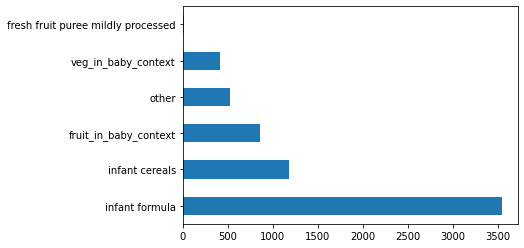

In [22]:
class_df['product_type'].value_counts().plot.barh()

# Using Current (not updated method) of Counting

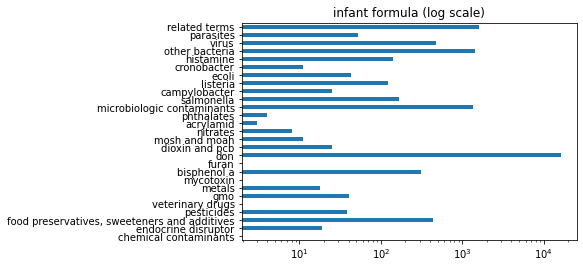

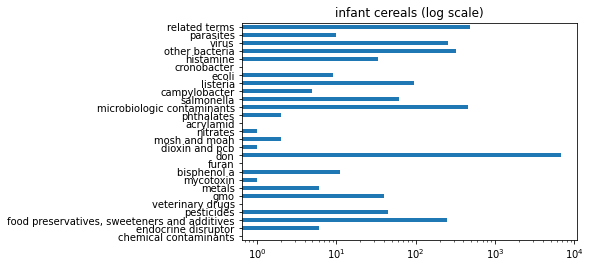

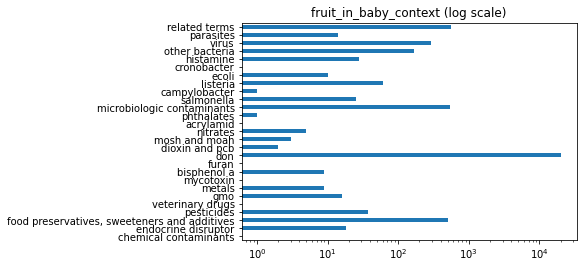

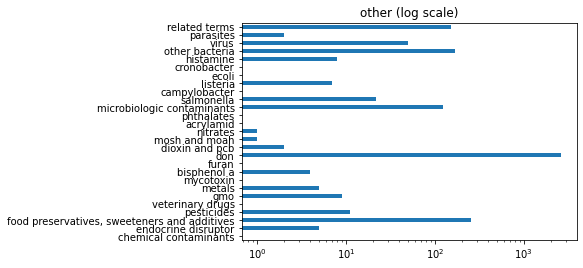

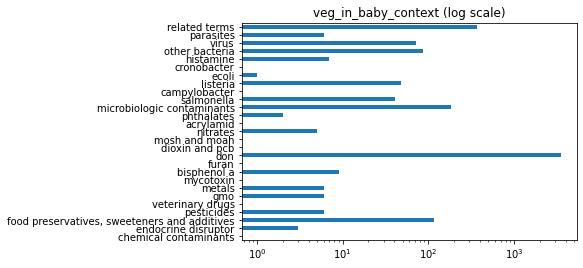

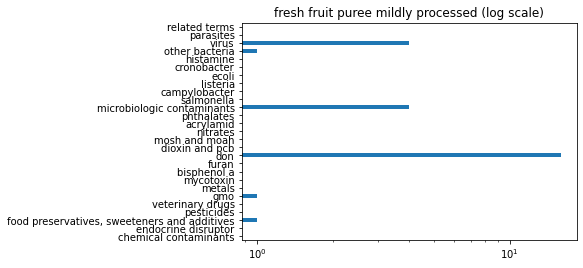

In [23]:
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    class_df.loc[class_df.product_type == category][hazards.keys()].sum(axis=0).plot.barh(title=category+ ' (log scale)', log=True)
    plt.show()


In [24]:
class_df.columns

Index(['infant formula', 'sterilized vegetable mixed with fish',
       'fresh fruit puree mildly processed', 'infant cereals', 'other',
       'chemical contaminants', 'endocrine disruptor',
       'food preservatives, sweeteners and additives', 'pesticides',
       'veterinary drugs', 'gmo', 'metals', 'mycotoxin', 'bisphenol a',
       'furan', 'don', 'dioxin and pcb', 'mosh and moah', 'nitrates',
       'acrylamid', 'phthalates', 'microbiologic contaminants', 'salmonella',
       'campylobacter', 'listeria', 'ecoli', 'cronobacter', 'histamine',
       'other bacteria', 'virus', 'parasites', 'related terms',
       'baby_food_brands', 'formula_brands', 'food_or_formula_brands',
       'cereal', 'baby_food', 'fruit', 'vegetable', 'baby',
       'fruit_in_baby_context', 'veg_in_baby_context', 'product_type'],
      dtype='object')

In [25]:
class_df.loc[class_df['bisphenol a'] > 0]['bisphenol a']

https://www.netmums.com/coffeehouse/being-mum-794/children-4-11-years-60/1857707-water-bottle-school-doesnt-leak.html                                           1
https://www.netmums.com/coffeehouse/home-garden-194/sustainable-living-612/1313693-head-spinning-my-home-toxic.html                                             2
https://www.netmums.com/coffeehouse/drop-clinic-984/bottle-feeding-559/279699-dr-browns-how-assemble-bottles.html                                               4
https://www.netmums.com/coffeehouse/drop-clinic-984/bottle-feeding-559/386187-avent-vs-tommee-tippee.html                                                       2
https://www.netmums.com/coffeehouse/becoming-mum-ttc-64/trying-baby-752/1145278-ttc-tips-x.html                                                                 1
                                                                                                                                                               ..
https://www.netmums.com/coff

In [26]:
class_df.loc[class_df['Endocrine disruptor'] > 0]['Endocrine disruptor']

KeyError: 'Endocrine disruptor'

# LDA Approach...

 how many possible cateorgires do we have?
 4 Products
 18 Hazards

 so we do
     * k = 4
     * k = 18
     * k = $18*4$ = 72


In [ ]:
#TODO: 
#we can try this approach at the post level and comment level.
# (IN ANOTHER JUPYTER NOTEBOOK)
